# Colab Interface

In [ ]:
colab_requirements = [
    "pip install torch",
    "pip install matplotlib",
    "pip install numpy",
    "pip install parafilt",
]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command(i)

# Inputs Signals

In [1]:
import numpy as np
from scipy.signal import fftconvolve

def example_signals(n_samples, filterlen, SNR):
    # Generate the unknown filter
    w = np.random.randn(filterlen)
    w /= np.linalg.norm(w)

    # Create the driving signal
    x = np.random.randn(n_samples)

    # Convolve with the unknown filter
    d_clean = fftconvolve(x, w)[:n_samples]

    # Add noise to the reference signal
    noise = np.random.randn(n_samples) * 10 ** (-SNR / 20.)
    d = d_clean + noise

    # Convert the signals to tensors and move to GPU
    d = torch.from_numpy(d).cuda().float().unsqueeze(0)
    x = torch.from_numpy(x).cuda().float()

    return d, x

# Run the Filters and Test Error Vectors

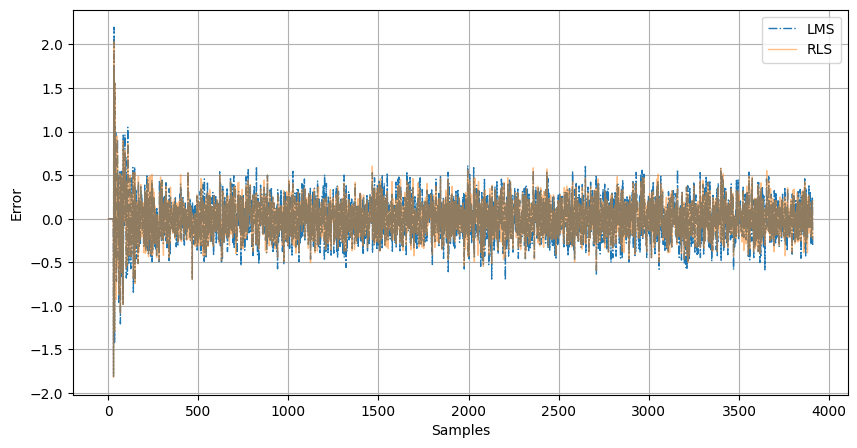

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import parafilt

# Parameters
hop = 1000
framelen = 2000
n_samples = 4000
filterlen = 30
learning_rate = 0.5

# Create input signals
d, x = example_signals(n_samples, filterlen, SNR=15)

# Create and apply the LMS filter
lms = parafilt.LMS(hop=hop, framelen=framelen, filterlen=filterlen, learning_rate=learning_rate).cuda()
d_est_lms, e_lms = lms(d, x)

# Create and apply the RLS filter
rls = parafilt.RLS(hop=hop, framelen=framelen, filterlen=filterlen).cuda()
d_est_rls, e_rls = rls.forward(d, x)

# Plot the error signals
plt.figure(figsize=(10, 5))
plt.plot(e_lms[0].cpu().numpy(), '-.', lw=1, label='LMS')
plt.plot(e_rls[0].cpu().numpy(), lw=1, label='RLS', alpha=0.5)
plt.ylabel("Error")
plt.xlabel("Samples")
plt.legend()
plt.grid()
plt.show()